In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


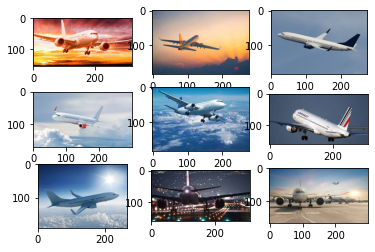

In [2]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = '/content/drive/MyDrive/Q7_new_dataset/train/airplane/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'airplane_000' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

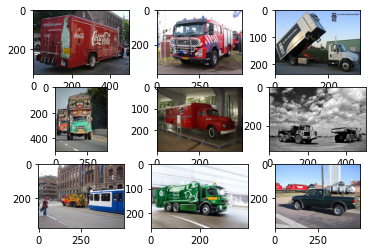

In [3]:

# plot cat photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = '/content/drive/MyDrive/q7_dataset/truck/train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'truck_0' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

In [4]:
# load dogs vs cats dataset, reshape and save to a new file
from os import listdir
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
# define location of dataset
folder = '/content/drive/MyDrive/q7_dataset/airplane/train/'
photos, labels = list(), list()
# enumerate files in the directory
for file in listdir(folder):
	# determine class
	output = 0.0
	if file.startswith('airplane'):
		output = 1.0
	# load image
	photo = load_img(folder + file, target_size=(200, 200))
	# convert to numpy array
	photo = img_to_array(photo)
	# store
	photos.append(photo)
	labels.append(output)
# convert to a numpy arrays
photos = asarray(photos)
labels = asarray(labels)
print(photos.shape, labels.shape)
# save the reshaped photos
save('airplane_vs_truck_photos.npy', photos)
save('airplane_vs_truck_labels.npy', labels)

(30, 200, 200, 3) (30,)


In [5]:
# load and confirm the shape
from numpy import load
photos = load('airplane_vs_truck_photos.npy')
labels = load('airplane_vs_truck_labels.npy')
print(photos.shape, labels.shape)

(30, 200, 200, 3) (30,)


# Model VGG 1

In [6]:
# baseline model for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = datagen.flow_from_directory('/content/drive/MyDrive/Q7_new_dataset/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('/content/drive/MyDrive/Q7_new_dataset/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=20, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 75.000


# Image Data Augmentation


In [7]:
# baseline model with data augmentation for the dogs vs cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generators
	train_datagen = ImageDataGenerator(rescale=1.0/255.0,
		width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	test_datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterators
	train_it = train_datagen.flow_from_directory('/content/drive/MyDrive/Q7_new_dataset/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = test_datagen.flow_from_directory('/content/drive/MyDrive/Q7_new_dataset/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 85.000


# Transfer Learning

In [9]:
# vgg16 model used for transfer learning on the dogs and cats dataset
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('/content/drive/MyDrive/Q7_new_dataset/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	test_it = datagen.flow_from_directory('/content/drive/MyDrive/Q7_new_dataset/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=10, verbose=1)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

Found 60 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1/1 [==============================] - 48s 48s/step - loss: 8.7455 - accuracy: 0.2667 - val_loss: 3.7028 - val_accuracy: 0.9000
Epoch 2/10
1/1 [==============================] - 40s 40s/step - loss: 1.0957 - accuracy: 0.9500 - val_loss: 4.3179 - val_accuracy: 0.9000
Epoch 3/10
1/1 [==============================] - 40s 40s/step - loss: 0.1084 - accuracy: 0.9833 - val_loss: 4.4056 - val_accuracy: 0.8500
Epoch 4/10
1/1 [==============================] - 40s 40s/step - loss: 6.6883e-15 - accuracy: 1.0000 - val_loss: 4.7231 - val_accuracy: 0.8500
Epoch 5/10
1/1 [==============================] - 40s 40s/step - loss: 1.9266e-22 - accuracy: 1.0000 - val_loss: 4.9831 - val_accuracy: 0.8500
Epoch 6/10
1/1 [==============================] - 40s 40s/step - loss: 2.0947e-28 - accuracy: 1.0000 - val_loss: 5.2020 - val_accuracy: 0.8500
Epoch 7/10
1/1 [==============================] - 40s 40s/step - loss: 4.5425e-33 - accuracy: 1.0000 - val_loss: 5.4123 - val_accuracy: 0.8500
Epoch 8/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 85.000


# Predict

In [10]:
# save the final model to file
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# define cnn model
def define_model():
	# load model
	model = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model = Model(inputs=model.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

# run the test harness for evaluating a model
def run_test_harness():
# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(featurewise_center=True)
	# specify imagenet mean values for centering
	datagen.mean = [123.68, 116.779, 103.939]
	# prepare iterator
	train_it = datagen.flow_from_directory('/content/drive/MyDrive/Q7_new_dataset/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
	# fit model
	model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
	# save model
	model.save('final_model.h5')

# entry point, run the test harness
run_test_harness()

Found 20 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


In [11]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img
 
# load an image and predict the class
def run_example():
	# load the image
	img = load_image('download.jpg') #download and test
	# load model
	model = load_model('final_model.h5')
	# predict the class
	result = model.predict(img)
	print(result[0])
 
# entry point, run the example
run_example()

[1.]


In [ ]:
# https://c8.alamy.com/comp/2BB72P3/typical-indian-truck-rajasthan-india-2BB72P3.jpg